## Accessing and visualizing ESA CCI version 4 data from the MAAP STAC catalog

### What are we doing in this notebook ?

In this tutorial, we make use of the [stackstac package](https://github.com/gjoseph92/stackstac) that allows us to turn a stack collection imported from the catalog with the [`pystac_client`](https://pystac-client.readthedocs.io/en/stable/) to an xarray dataset, and we plot the time series of the mean aboveground biomass for a selected tile of the dataset across the available temporal range.

### Requirements

Create a conda environment with a configuration file to which you will paste the following

Make the `esa-cci` environment available as a notebook kernel and choose it to run this notebook. 

In [1]:
from stackstac import stack, mosaic
import pystac_client
import matplotlib.pyplot as plt 
import numpy as np
import pystac

We first create a client to access the STAC test catalog.

In [2]:
URL = "https://stac.maap-project.org"
catalog = pystac_client.Client.open(URL)

We create a bounding box of interest to find the tile that covers a small region around manaus, brazil (amazon rainforest).

In [3]:
bbox = [-55,-6,-54.8,-5.8]

We proceed to an item search in the catalog using the `pystac-client`, filtering items covering our area of interest.

In [4]:
stac_collection = catalog.search(
    collections=["ESACCI_Biomass_L4_AGB_V4_100m"],
    bbox=bbox
)

Let's take a quick look at the results of the search. We may be for example interested in knowing where the data is stored.

In [5]:
stac_collection.get_all_items()[0].assets['estimates'].href

/opt/conda/envs/esa-cci/lib/python3.10/site-packages/pystac_client/item_search.py:841: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


's3://nasa-maap-data-store/file-staging/nasa-map/ESACCI_Biomass_L4_AGB_V4_100m_2020/N00W060_ESACCI-BIOMASS-L4-AGB-MERGED-100m-2020-fv4.0.tif'

We turn the resulting set of items (we expect one item here in the result, given the size of our bounding box) into an xarray DataArray using `stackstac`

In [6]:
dask_array = stack(stac_collection.get_all_items())

/opt/conda/envs/esa-cci/lib/python3.10/site-packages/stackstac/prepare.py:364: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


We can see that our array has the following dimensions : time (we have four data points, one for each year), latitude, longitude and band (we have two bands : the AGB estimates and the AGB standard deviation)

In [7]:
dask_array

<xarray.DataArray 'stackstac-c81ceb3d41889578ee425038e6d84266' (time: 4,
                                                                band: 2,
                                                                y: 11250,
                                                                x: 11251)>
dask.array<fetch_raster_window, shape=(4, 2, 11250, 11251), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/13)
  * time            (time) datetime64[ns] 2017-01-01 2018-01-01 ... 2020-01-01
    id              (time) <U52 'N00W060_ESACCI-BIOMASS-L4-AGB-MERGED-100m-20...
  * band            (band) <U18 'estimates' 'standard_deviation'
  * x               (x) float64 -60.0 -60.0 -60.0 -60.0 ... -50.0 -50.0 -50.0
  * y               (y) float64 0.0 -0.0008889 -0.001778 ... -9.998 -9.999
    proj:shape      object {11250}
    ...              ...
    proj:transform  object {0.0, 1.0, -0.00088888888888, -60.0, 0.00088888888...
    proj:bbox       object {0.0, -60.0, -50.0000000001, -9.9999999999}
    proj:epsg       int64 4326
    description     (band) <U49 'Cloud Optimized GeoTIFF of AGB estimates' 'C...
    title           (band) <U49 'Cloud Optimized GeoTIFF of AGB estimates' 'C...
    epsg            int64 4326
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(-60.00088888828888, -9.9999999...
    crs:         epsg:4326
    transform:   | 0.00, 0.00,-60.00|\n| 0.00,-0.00, 0.00|\n| 0.00, 0.00, 1.00|
    resolution:  0.00088888888888

We want to take a look at the time series of the average AGB in our tile. Let's compute this.

In [8]:
mean_time_series = dask_array.sel(band='estimates').mean(['x','y']).compute()

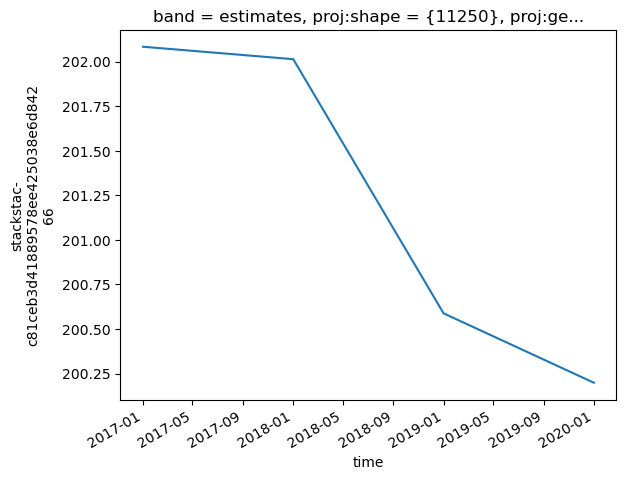

In [9]:
mean_time_series.plot()